In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
import pickle

print(tf.__version__)

2024-12-10 20:31:27.537046: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 20:31:27.543700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 20:31:27.551718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 20:31:27.554195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 20:31:27.560049: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpuid = 0 #int(args.gpu_id)                                                                                                                           
if gpus:
  # Restrict TensorFlow to only allocate X GB of memory on the first GPU                                                                              
  try:
    tf.config.set_visible_devices(gpus[gpuid], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpuid], True)
    '''
    tf.config.set_logical_device_configuration(
        gpus[gpuid],
        [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
    '''
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized                                                                                   
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1733887890.041999   20278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733887890.066754   20278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733887890.069209   20278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733887890.072058   20278 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    inputs = np.load("all_inputs_3.npy")

In [5]:
inputs[0][0]

array([[0.7647059 ],
       [0.7294118 ],
       [0.6313726 ],
       ...,
       [0.49803922],
       [0.5529412 ],
       [0.6313726 ]], dtype=float32)

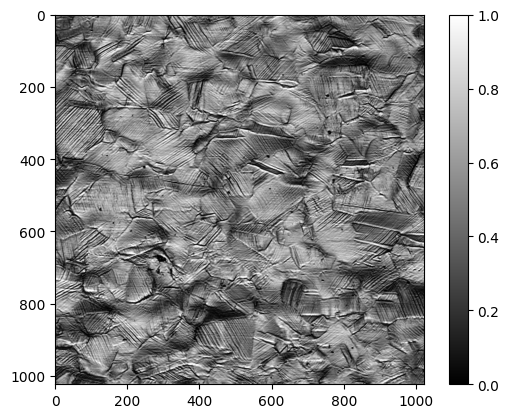

In [5]:
plt.imshow(inputs[0],cmap='grey')
plt.colorbar()

In [4]:
batchsize = 32

with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    targets = np.load("all_targets_3.npy")
    # train test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(inputs, targets, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

with tf.device("/CPU:0") :
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
with tf.device("/GPU:0") :
    train_dataset = train_dataset.shuffle(buffer_size=300).batch(batchsize)
    val_dataset = val_dataset.shuffle(buffer_size=300).batch(batchsize)

In [7]:
inputs.shape

(3467, 1024, 1024, 1)

In [6]:
conv_dim = 16
ff_dim = 32
k_dim = 5
pool_dim = 5
drop_rate = 0.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu', input_shape=(1024, 1024, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 1020, 1020, 16) │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1020, 1020, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 1020, 1020, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 204, 204, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 204, 204, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 200, 200, 16)   │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200, 200, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 200, 200, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 40, 40, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 36, 36, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 36, 36, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 36, 36, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 7, 7, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,593 (150.75 KB)

 Trainable params: 38,497 (150.38 KB)

 Non-trainable params: 96 (384.00 B)

In [7]:
#model.compile(optimizer=Adam(learning_rate=1e-4),
#model.compile(optimizer=Adam(learning_rate=1e-2),
#model.compile(optimizer=Adam(learning_rate=1e-5),
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [10]:
model_checkpoint = ModelCheckpoint(
  filepath='checkpoint.model3.keras',
  monitor='val_loss',
  mode='min',
  save_best_only=True)

optim = model.fit(train_dataset,
                  validation_data=val_dataset, 
                  epochs=100, 
                  callbacks=[model_checkpoint])

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6049 - loss: 0.6751

E0000 00:00:1733888020.584806   77273 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733888020.668165   77273 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733888021.685377   77251 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733888021.766244   77251 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.6057 - loss: 0.6741 - val_accuracy: 0.4685 - val_loss: 0.9482
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8112 - loss: 0.4186 - val_accuracy: 0.4685 - val_loss: 0.7518
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8505 - loss: 0.3482 - val_accuracy: 0.5315 - val_loss: 0.8308
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8273 - loss: 0.3864 - val_accuracy: 0.5315 - val_loss: 3.3477
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9094 - loss: 0.2245 - val_accuracy: 0.5315 - val_loss: 2.7551
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9036 - loss: 0.2354 - val_accuracy: 0.6162 - val_loss: 0.7088
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9307 - loss: 0.1699 - val_accuracy: 0.5838 - val_loss: 1.2654
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9159 - loss: 0.2088 - val_accuracy: 0.7405 - val

In [10]:
optim.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

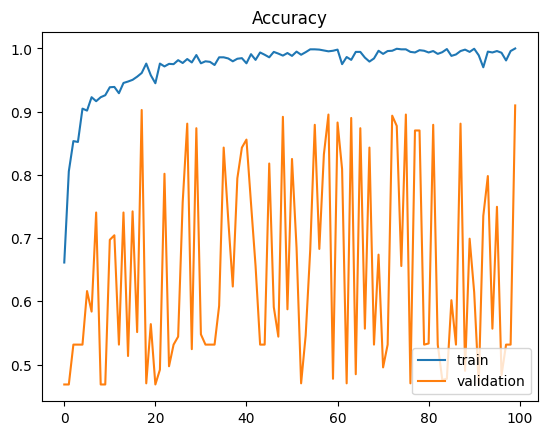

In [11]:
plt.plot(optim.history['accuracy'])
plt.plot(optim.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Accuracy')
plt.show()

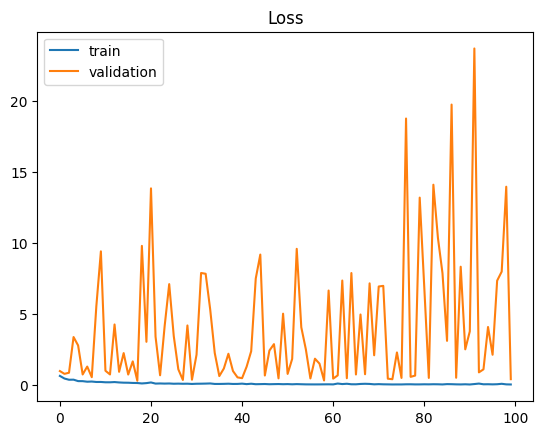

In [12]:
plt.plot(optim.history['loss'])
plt.plot(optim.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Loss')
plt.show()

In [13]:
np.array(optim.history['val_accuracy']).max()

0.9099099040031433

In [14]:
from tensorflow.keras.models import load_model

best_model = load_model('checkpoint.model3.keras')

In [15]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9017 - loss: 0.2411

E0000 00:00:1733888593.009588   77262 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733888593.093079   77262 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733888593.176960   77262 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9036 - loss: 0.2364


In [16]:
'Test loss:{0}, Test accuracy: {1}'.format(test_loss,test_acc)

'Test loss:0.21284082531929016, Test accuracy: 0.9135446548461914'

In [8]:
# Predict the values from the testing dataset
Y_pred_probs = best_model.predict(X_test)
Y_pred = np.array(Y_pred_probs>=.5)
# compute the confusion matrix
#confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred) 

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


Text(0, 0.5, 'freq')

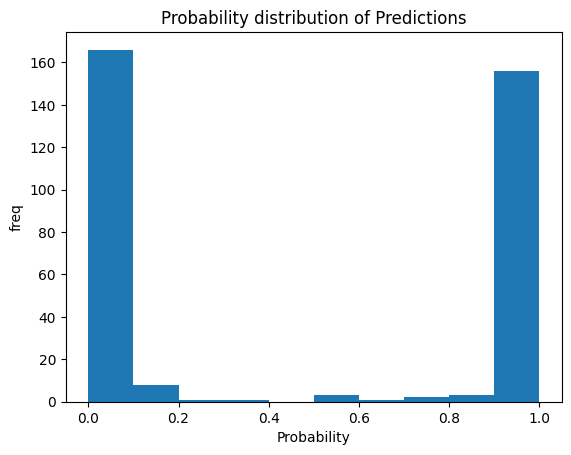

In [9]:
plt.hist(Y_pred_probs.flatten())
plt.title('Probability distribution of Predictions')
plt.xlabel('Probability')
plt.ylabel('freq')

Text(0, 0.5, 'freq')

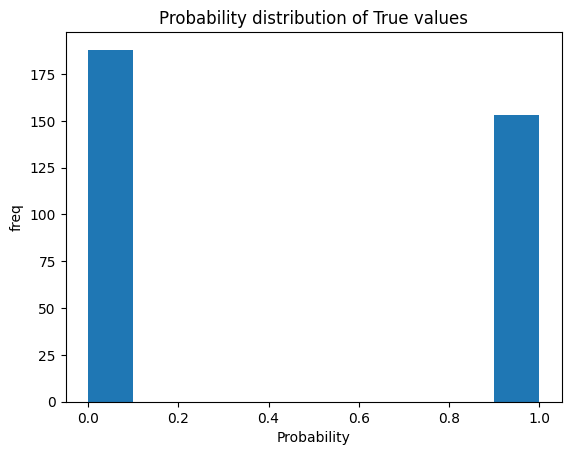

In [10]:
plt.hist(y_test)
plt.title('Probability distribution of True values')
plt.xlabel('Probability')
plt.ylabel('freq')

In [1]:
sum(y_test)

NameError: name 'y_test' is not defined

In [12]:
Y_pred = Y_pred.astype(float).flatten()

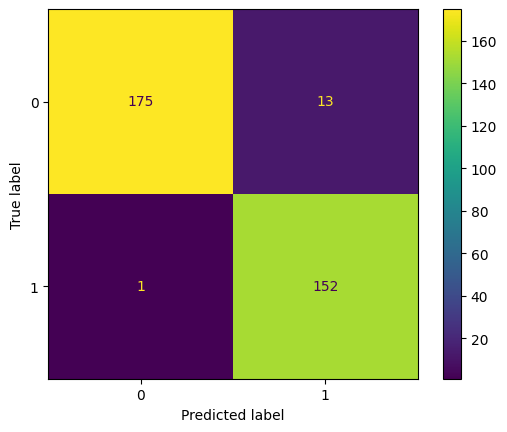

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, Y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [17]:
TP=152
TN=175
FP=13
FN=1

In [18]:
recall = TP/(TP+FN)
precision = TP/(TP+FP)

print(recall,precision)

0.9934640522875817 0.9212121212121213


In [19]:
(TP+TN)/(TP+TN+FP+FN)

0.9589442815249267